# Overpass example pipeline

This pipeline generates a dataset with path gain information by Sionna RT and features in 256x256 windows.

It searches for a place on open street map and acquires geospatial data using Overpass API. It is nice for quick sketches, but larger areas take too much time to process.

In [34]:
import logging
from pathlib import Path
import json
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from rm_gen import data_manipulation, data_source, features, ground_truth
from rm_gen.core import Pipeline

In [2]:
# OPTIONAL: Set up a custom logger for the pipeline
# use debug level for more detailed output
logger = logging.Logger("rm_gen_pipeline_logger")
logger.setLevel(logging.INFO)
# logger.setLevel(logging.DEBUG)
handler = logging.StreamHandler()
handler.setFormatter(logging.Formatter("[%(levelname)s] %(message)s"))
logger.addHandler(handler)

Pipeline.set_default_logger(logger)

In [3]:
# CREATING SCENARIO DEFINITION PIPELINE

############################################
# place to get building footprints from OSM
building_footprints_source_step = data_source.BuildingFootprintFromOSMPlace(
    place_query="Plano Piloto, Brasília, DF, Brasil",
)
############################################

############################################
# defining the minimum and maximum building heights to be randomly assigned
# to the building footprints obtained from OSM
building_heights_source_step = data_source.RandomBuildingHeight(
    min_height=6.6,
    max_height=19.8,
)
############################################

############################################
# this defines an axis aligned bounding box to be applied after transforming
# building footprints to a local coordinate system (in meters)
local_coords_bbox = ((0., 0.), (2e6, 13643))
# we actually just want to clip y axis because of some isolated buildings,
# so we set a huge x range and a tighter y range

# defining origin at bottom left makes defining this bbox easier
local_coords_origin_at = "bottom_left"

local_coordinates_transformation_step = data_manipulation.BuildingFootprintToLocalCoords(
    local_coords_bbox=local_coords_bbox,
    origin_at=local_coords_origin_at,
)
############################################

############################################
# make 256x256 m grids with 256 m step
grid_len = (256, 256)  # in meters
grid_step = (256, 256)  # in meters
grid_resolution = (1.0, 1.0)  # in meters

grid_windows_generation_step = data_manipulation.GenerateScenariosInGrids(
    resolution=grid_resolution,
    grid_len=grid_len,
    grid_step=grid_step,
)
############################################

############################################
# transmitter positions will be generated on top of buildings
height_above_building = 3.0  # in meters
min_building_height_for_tx = 6.6  # in meters
step_between_tx_along_building_edge = 12.0  # in meters
transmitter_positions_generation_step = data_manipulation.GenerateCandidateTransmittersOnBuildings(
    height_above_building=height_above_building,
    min_building_height=min_building_height_for_tx,
    step=step_between_tx_along_building_edge,
)
############################################


scenario_definition_pipeline = Pipeline([
    building_footprints_source_step,
    building_heights_source_step,
    ## Depends on building footprints
    local_coordinates_transformation_step,
    ## Depends on building footprints in local coords [m]
    transmitter_positions_generation_step,
    # ## Depends on local coord sys
    grid_windows_generation_step,
])

scenario_definition_pipeline.set_cache_dir(
    Path("./cache/examples/overpass_example")
)

scenario_definition_pipeline_results = scenario_definition_pipeline.run()

[INFO] Starting step BuildingFootprintFromOSMPlace   
[INFO] Number of building footprints loaded 7178     
[INFO] Starting step RandomBuildingHeight                     
[INFO] Starting step BuildingFootprintToLocalCoords           
[INFO] Starting step GenerateCandidateTransmittersOnBuildings 
Generating candidate tx on buildings: 100%|██████████| 7101/7101 [00:08<00:00, 837.31it/s] 
[INFO] Generated 84574 candidate transmitter locations       
[INFO] Starting step GenerateScenariosInGrids                
[INFO] Generated 3834 grids over local coordinate system     
Pipeline Steps: 100%|██████████| 5/5 [01:53<00:00, 22.63s/it]


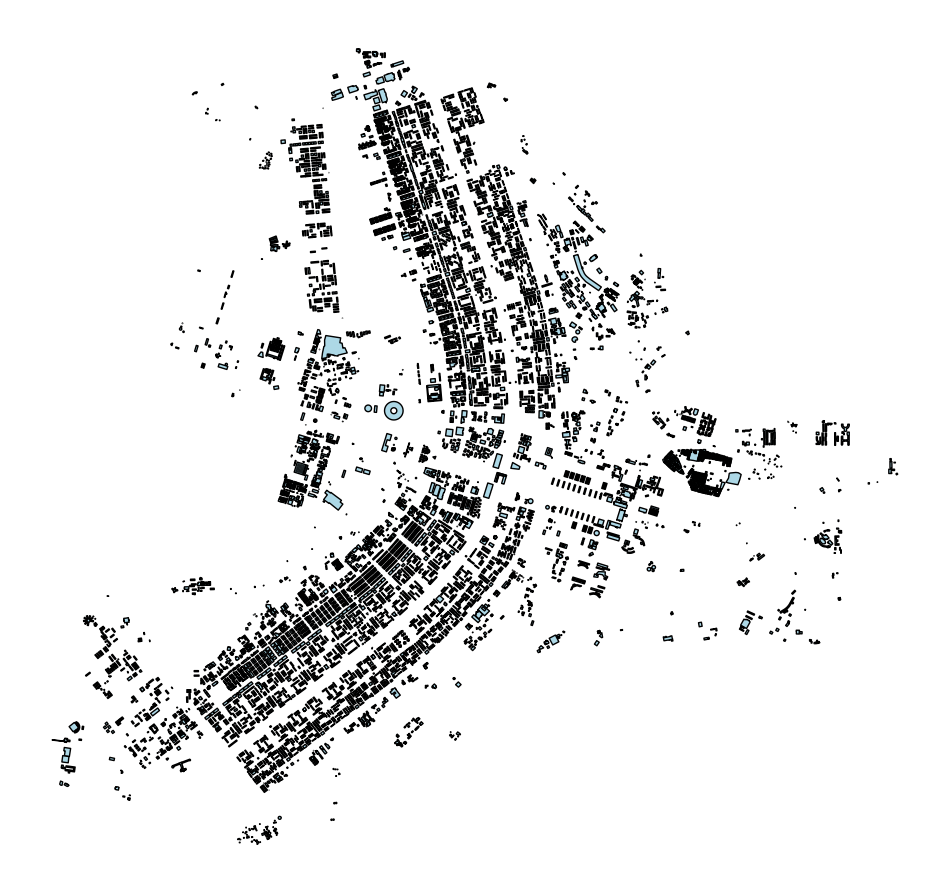

In [4]:
buildings = scenario_definition_pipeline_results["context"]["local_building_footprints"]
# streets = ox.graph_from_place(place_query, network_type='drive')
# streets = ox.project_graph(streets)
# street_edges_utm = ox.graph_to_gdfs(streets, nodes=False)

fig, ax = plt.subplots(figsize=(12,12))

buildings.plot(ax=ax, edgecolor='black', facecolor='lightblue')

# tx_pos.plot(ax=ax, edgecolor='red', facecolor='pink', label="Posição candidata para TX")

# ax.set_xlim((256*19, 21*256))
# ax.set_ylim((1536 + 5*256, 1536 + 7*256))
ax.set_aspect('equal')
ax.axis('off')
# ax.legend()
plt.show()


In [5]:
dataset_dir = Path("./dataset/examples/overpass_dataset")

dataset_dir.mkdir(parents=True, exist_ok=True)

# we add an epsilon margin so that if a building is exactly at min or max height,
# it is still included in the dataset
min_repr_height = building_heights_source_step.min_height - 1e-3
max_repr_height = (
    transmitter_positions_generation_step.height_above_building
    + building_heights_source_step.max_height
    + 1e-3
)

# minimum percentage of building that must be present in a grid
# to not mask the building height raster feature
# (to avoid grids with very little building data, and thus very simple propagation scenarios)
mask_when_perc_of_building_less_than = 0.1  # 10%

# to avoid grids with no transmitters at all (if for some reason they do appear),
# we also mask the transmitter height raster feature
mask_when_num_of_tx_less_than = 1

# masking is applied by collecting the window indices
# where the condition is not met, so that we can ignore them afterwards

features_pipeline = Pipeline([
    features.FeatureBuildingHeightRasterOnGrids(
        dataset_dir=dataset_dir,
        min_h=min_repr_height,
        max_h=max_repr_height,
        mask_when_perc_of_building_less_than=mask_when_perc_of_building_less_than,
    ),
    features.FeatureTxHeightRasterOnGrids(
        dataset_dir=dataset_dir,
        min_h=min_repr_height,
        max_h=max_repr_height,
        mask_when_num_of_tx_less_than=1,
    ),
])

features_pipeline.set_cache_dir(
    Path("./cache/examples/overpass_example")
)

features_pipeline_results = features_pipeline.run(
    # passing the scenario definition context to the features pipeline
    scenario_definition_pipeline_results["context"]
)

[INFO] Starting step FeatureBuildingHeightRasterOnGrids
[INFO] Saved building height feature grids to folder /home/artistreak/projects/personal/rm-gen/examples/dataset/examples/overpass_dataset/building_height_6.598999999999999_22.801000000000002
[INFO] Starting step FeatureTxHeightRasterOnGrids            
Saving tx height feature grids: 100%|██████████| 3834/3834 [00:23<00:00, 160.18it/s]
[INFO] Saved tx height feature grids to folder /home/artistreak/projects/personal/rm-gen/examples/dataset/examples/overpass_dataset/tx_height_6.598999999999999_22.801000000000002
Pipeline Steps: 100%|██████████| 2/2 [00:28<00:00, 14.42s/it]


In [6]:
#########################
# Now, we create the dataset feature structure
#########################
total_num_of_samples = 0
features_per_window = []

grid_definitions = scenario_definition_pipeline_results["context"]["grid_definitions"]

for grid_idx in tqdm(
    range(len(grid_definitions["bboxes"])),
    total=len(grid_definitions["bboxes"])
):
    # skip masked grids
    if grid_idx in grid_definitions["dangerously_mutable__masked_indices"]:
        continue

    feature_files = {}
    skip_samples = False
    num_samples = 0

    for feature_name in features_pipeline_results["feature_names"]:
        # get feature files for this grid
        feature_acq = features_pipeline_results["context"][feature_name]
        feature_files_for_grid = feature_acq["feature_files_for_grid"]
        files = feature_files_for_grid[grid_idx]

        if isinstance(files, list):
            # make sure all features have some samples per grid
            if len(files) == 0:
                skip_samples = True
                break

            # make sure that, if they have multiple samples per grid,
            # they have the same number of samples
            if num_samples == 0:
                num_samples = len(files)
            elif num_samples != len(files):
                raise ValueError(
                    "Different number of samples for different features in the same grid"
                )
        elif isinstance(files, Path) or isinstance(files, str):
            # or they have 1 sample per grid
            files = Path(files)
        else:
            raise ValueError("get_feature_files_for_grid must return str or list of str")

        # store feature files
        feature_files[feature_name] = str(files) if isinstance(files, Path) else [str(f) for f in files]

    if skip_samples:
        continue

    total_num_of_samples += num_samples

    features_per_window.append({
        "grid_idx": grid_idx,
        "features": feature_files,
        "num_samples": num_samples,
    })

print("Total samples:", total_num_of_samples)
# now we need to save the dataset structure in a json file
L_max = 127
# d_min = 6.6 + 3 - 1.5 # (min building height + tx height - rx height)
# f = 7e9
# fspl_min = 20 * np.log10(4 * np.pi / 3e8) + 20 * np.log10(d_min) + 20 * np.log10(f)
# L_min = fspl_min
L_min = 67

dataset_structure = {
    "train": [],
    "val": [],
    "test": [],
    "max_path_gain": -L_min,
    "min_path_gain": -L_max,
    "min_height": building_heights_source_step.min_height,
    "max_height": (
        building_heights_source_step.max_height
        + transmitter_positions_generation_step.height_above_building
    ),
}
print(dataset_structure)
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

accumulated_samples = 0
for sample_idx, pairing in enumerate(features_per_window):
    num_samples = pairing["num_samples"]
    if accumulated_samples <= total_num_of_samples * train_ratio:
        split = "train"
    elif accumulated_samples <= total_num_of_samples * (train_ratio + val_ratio):
        split = "val"
    else:
        split = "test"
    for i in range(pairing["num_samples"]):
        sample = {
            feature_name: (
                pairing["features"][feature_name][i]
                if isinstance(pairing["features"][feature_name], list)
                else pairing["features"][feature_name]
            )
            for feature_name in features_pipeline_results["feature_names"]
        }
        dataset_structure[split].append(sample)

    accumulated_samples += num_samples

with open(dataset_dir / "dataset_structure.json", "w") as f:
    json.dump(dataset_structure, f, indent=4)
################################
print("Training samples: ", len(dataset_structure["train"]))
print("Validation samples: ", len(dataset_structure["val"]))
print("Test samples: ", len(dataset_structure["test"]))

100%|██████████| 3834/3834 [00:00<00:00, 44690.19it/s]


Total samples: 67222
{'train': [], 'val': [], 'test': [], 'max_path_gain': -67, 'min_path_gain': -127, 'min_height': 6.6, 'max_height': 22.8}
Training samples:  53915
Validation samples:  6644
Test samples:  6663


In [7]:
################################
# CREATING SIMULATION PIPELINE
################################
simulation_pipeline = Pipeline([
    data_manipulation.CreateFullMitsubaScene(),
    ground_truth.SionnaRadiomapOnGrids(
        dataset_dir=dataset_dir,
        frequency=7e9,
        # honestly not needed for path gain calculation
        bandwidth=10e6,
        number_of_rays=10**7,
        number_of_interactions=2,
        min_gain=-L_max,
        max_gain=-L_min,
    ),
])

simulation_pipeline.set_cache_dir(
    Path("./cache/examples/overpass_example")
)

######################################
# artificially set to only run one simulation, for testing purposes
grid_definitions = features_pipeline_results["context"]["grid_definitions"]

inactive_indices = grid_definitions["dangerously_mutable__masked_indices"]

num_grids = len(grid_definitions["bboxes"])
all_indices = range(num_grids)
positive_indices = np.setdiff1d(all_indices, list(inactive_indices))

keep_positive = positive_indices[:2]

prev_definition = grid_definitions["dangerously_mutable__masked_indices"]
grid_definitions["dangerously_mutable__masked_indices"] = list(
    set(all_indices) - set(keep_positive)
)
######################################
simulation_pipeline_results = simulation_pipeline.run(
    features_pipeline_results["context"]
)
grid_definitions["dangerously_mutable__masked_indices"] = prev_definition


[INFO] Starting step CreateFullMitsubaScene          
Creating building meshes: 100%|██████████| 7089/7089 [00:11<00:00, 626.90it/s]
[INFO] Skipping 0 buildings due to invalid geometry  
[INFO] Starting step SionnaRadiomapOnGrids                   
Pipeline Steps:  50%|█████     | 1/2 [00:13<00:13, 13.10s/it]







Different tx positions: 100%|██████████| 7/7 [00:41<00:00,  6.00s/it]








Generating Sionna Radiomap on Grids: 100%|██████████| 3834/3834 [01:31<00:00, 41.99it/s]
[INFO] Saved tx height feature grids to folder /home/artistreak/projects/personal/rm-gen/examples/dataset/examples/overpass_dataset/sionna_ground_truth_-127_-67_2_10000000_7000000000.0
Pipeline Steps: 100%|██████████| 2/2 [01:46<00:00, 53.48s/it]


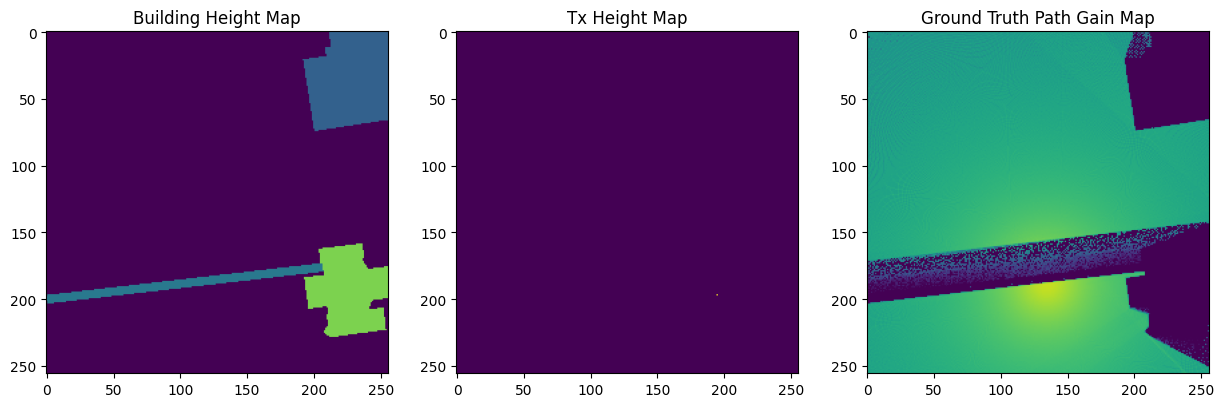

In [8]:
# plot features and ground truth for a sample grid
import matplotlib.pyplot as plt
ground_truth_folder = simulation_pipeline_results["context"]["sionna_ground_truth"]["folder"]
tx_height_map_folder = features_pipeline_results["context"]["tx_height"]["folder"]
building_height_map_folder = features_pipeline_results["context"]["building_height"]["folder"]

grid_idx = keep_positive[0]
tx_idx = 50
ground_truth_file = (
    ground_truth_folder
    / f"{grid_idx}_{tx_idx}.png"
)
tx_height_map_file = (
    tx_height_map_folder
    / f"{grid_idx}_{tx_idx}.png"
)
building_height_map_file = (
    building_height_map_folder
    / f"{grid_idx}.png"
)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].set_title("Building Height Map")
axs[0].imshow(plt.imread(building_height_map_file), vmin=0, vmax=1)
axs[1].set_title("Tx Height Map")
axs[1].imshow(plt.imread(tx_height_map_file), vmin=0, vmax=1)
axs[2].set_title("Ground Truth Path Gain Map")
axs[2].imshow(plt.imread(ground_truth_file), vmin=0, vmax=1)
plt.show()
